<a href="https://colab.research.google.com/github/vaishjah3/ML-Algorithms/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [ ]:
data_transforms={
    'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ]),
    'val':transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

In [ ]:
!unzip /content/hymenoptera_data.zip

Archive:  /content/hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/an

In [ ]:
data_dir='hymenoptera_data'
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
data_loader={x:torch.utils.data.DataLoader(image_datasets[x],
                                           batch_size=4,
                                           shuffle=True) for x in ['train', 'val']}

dataset_size={x:len(image_datasets[x]) for x in ['train', 'val']}

class_name=image_datasets['val'].classes

In [ ]:
print('Class names:{}'.format(class_name))

Class names:['ants', 'bees']


In [ ]:
for i in ['train','val']:
  print('Dataset size of {} is {}'.format(i,dataset_size[i]))

Dataset size of train is 244
Dataset size of val is 153


In [ ]:
print("There are {} batches in the training set".format(len(data_loader['train'])))

There are 61 batches in the training set


152

Without delving too deep into the internals of pytorch, I can offer a simplistic answer:

Recall that when initializing optimizer you explicitly tell it what parameters (tensors) of the model it should be updating. The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.

More info on computational graphs and the additional "grad" information stored in pytorch tensors can be found in this answer.

Referencing the parameters by the optimizer can sometimes cause troubles, e.g., when the model is moved to GPU after initializing the optimizer. Make sure you are done setting up your model before constructing the optimizer. See this answer for more details.

In [ ]:
model_conv=torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [ ]:
for param in model_conv.parameters():
  param.requires_grad=False

In [ ]:
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs, 2)

In [ ]:
if torch.cuda.is_available():
  model_conv=model_conv.cuda()

In [ ]:
iteration=0
correct=0
for inputs, labels in data_loader['train']:
  if iteration==1:
    break
  iteration+=1
  inputs=Variable(inputs)
  labels=Variable(labels)
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()
  output=model_conv(inputs)
  _,predicted=torch.max(output, 1)
  correct+=(predicted==labels).sum()

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    correct = 0
    total = 0
    for images, labels in data_loader['train']:
      if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

      optimizer.zero_grad()
      outputs = model_conv(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      #print(labels)
      #print(len(images[0][0][0]))
      #print(images.size())
      #print(images.size(1))
      #print(labels.size(1))
      total += labels.size(0)

    train_acc = 100 * correct / total
    print("Epoch[{}/{}], Loss: {:.4f}, Train_accuracy: {:.2f}%".format(epoch+1, num_epochs, loss.item(), train_acc))


Epoch[1/25], Loss: 0.7237, Train_accuracy: 87.70%
Epoch[2/25], Loss: 1.5979, Train_accuracy: 88.93%
Epoch[4/25], Loss: 0.5979, Train_accuracy: 85.66%
Epoch[5/25], Loss: 0.3058, Train_accuracy: 84.84%
Epoch[6/25], Loss: 0.1310, Train_accuracy: 84.84%
Epoch[7/25], Loss: 0.5758, Train_accuracy: 81.97%
Epoch[8/25], Loss: 0.2749, Train_accuracy: 86.48%
Epoch[9/25], Loss: 0.9118, Train_accuracy: 84.84%
Epoch[10/25], Loss: 0.0378, Train_accuracy: 86.07%
Epoch[11/25], Loss: 0.0490, Train_accuracy: 82.38%
Epoch[12/25], Loss: 0.1993, Train_accuracy: 82.79%
Epoch[13/25], Loss: 0.1330, Train_accuracy: 82.79%
Epoch[14/25], Loss: 0.2019, Train_accuracy: 81.15%
Epoch[15/25], Loss: 0.0181, Train_accuracy: 83.20%
Epoch[16/25], Loss: 0.2869, Train_accuracy: 81.15%
Epoch[17/25], Loss: 0.3449, Train_accuracy: 84.02%
Epoch[18/25], Loss: 0.2332, Train_accuracy: 86.07%
Epoch[19/25], Loss: 0.1374, Train_accuracy: 84.84%
Epoch[20/25], Loss: 1.2817, Train_accuracy: 84.43%
Epoch[21/25], Loss: 0.9868, Train_accur

In [ ]:
model_conv.eval()
with torch.no_grad():
  correct=0
  total=0
  for images, labels in data_loader['val']:
    images=Variable(images)
    labels=Variable(labels)
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    outputs=model_conv(images)
    _,predicted=torch.max(outputs, 1)
    #print(predicted)
    #print(labels)
    total+=labels.size(0)
    correct += (predicted==labels).sum().item()
  print("Total accuracy {:.3f}".format((correct/total)*100))


Total accuracy 95.425


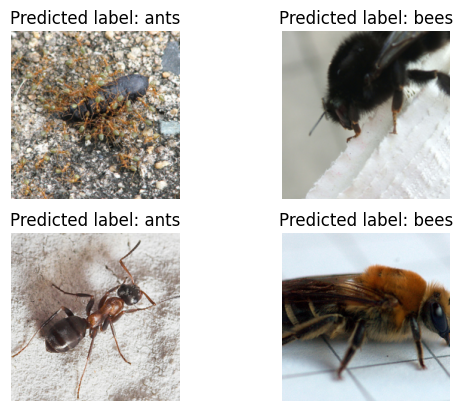

In [53]:
import matplotlib.pyplot as plt
fig=plt.figure()
show_batch=0
index=0
with torch.no_grad():
  for images, labels in data_loader['val']:
    if show_batch==1:
      break
    show_batch+=1
    images=Variable(images)
    labels=Variable(labels)
    if torch.cuda.is_available():
      images=images.cuda()
      labels=labels.cuda()
    outputs=model_conv(images) #dim=(4,2)
    _,predicted=torch.max(outputs, 1) #dim=(4)

    for i in range(4):
      index+=1
      ax=plt.subplot(2,2,index)
      ax.axis('off')
      ax.set_title('Predicted label: {}'.format(class_name[predicted[i]]))
      input_image=images.cpu().data[i]
      inp=input_image.numpy().transpose((1,2,0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp=std*inp+mean
      inp=np.clip(inp,0,1)
      plt.imshow(inp)





